In [27]:
import ast
import pandas as pd
from datasets import load_dataset

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category= FutureWarning)

In [2]:
# Load the 'recetasdelaabuela' dataset from Hugging Face
dataset = load_dataset("somosnlp/recetasdelaabuela", 'version_inicial')
# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(dataset['train'])

# Display the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Id', 'Nombre', 'URL', 'Ingredientes', 'Pasos', 'Pais', 'Duracion', 'Porciones', 'Calorias', 'Categoria', 'Contexto', 'Valoracion y Votos', 'Comensales', 'Tiempo', 'Dificultad', 'Categoria 2', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
        num_rows: 20085
    })
})


### Data Cleaning

1. Converted all column names and string values to lowercase for consistency. 

2. Mapped the 'Dificultad' column from descriptive values (e.g., "muy baja", "muy alta") to numerical values (1 to 5) using a dictionary.
3. Converted the 'Pasos' and 'Ingredientes' columns from string representations of lists to space-separated strings.
4. Split the 'Valoración y votos' column into two separate columns: 'valoracion' (float) and 'votos' (integer).
5. Extracted the numeric value from the 'Comensales' column to keep only the number of guests.
6. Dropped the 'Id' & 'Valoración y votos' column and any columns with "Unnamed" in their names.

In [3]:
# name for a function to convert any column from a string representation of a list to a space-separated string.
def convert_list_to_string(input_string):
    """
    Convert a column from a string representation of a list to a space-separated string.
    """
    if isinstance(input_string, str) and '[' in input_string:
        # Convert the string representation of a list to an actual list
        try:
            return ' '.join(ast.literal_eval(input_string))
        except (ValueError, SyntaxError):
            # If conversion fails, pass and return the original value
            pass
    return input_string      

def convert_valoracion_y_votos(input_string):
    """
    Convert the 'Valoración y votos' column to separate 'valoracion' and 'votos' columns.
    Example:
    >>> convert_valoracion_y_votos('Valoración: 4,5 (2 votos)')
    0    4.5
    1    2.0
    dtype: float64
    """
    if isinstance(input_string, str) and ':' in input_string:
        # Split the string into valoracion and votos
        try:
            valoracion, votos = input_string.split(':')[1].split('(')
            # Extract the numeric values
            valoracion = float(valoracion.split(' ')[1].replace(',', '.'))
            votos = int(votos.split(' ')[0])
            return pd.Series([valoracion, votos])
        except (ValueError, SyntaxError):
            # If conversion fails, pass and return None
            pass
    return pd.Series([None, None])  # Return None for both columns if conversion fails                                

In [4]:
# convert all column names to lowercase
df.columns = df.columns.str.lower()

# convert Dificultidad column from 1 to 5 where muy baja is 1 and muy alta is 5. using a dictionary
dificultidad_map = {
    'muy baja': 1,
    'baja': 2,
    'media': 3,
    'alta': 4,
    'muy alta': 5
}
df['dificultad'] = df['dificultad'].str.replace('Dificultad ','').map(dificultidad_map)

df['pasos'] = df['pasos'].apply(lambda ss: convert_list_to_string(ss)) # Convert the 'Pasos' column
df['ingredientes'] = df['ingredientes'].apply(lambda ss: convert_list_to_string(ss)) # Convert the 'Ingredientes' column

# convert 'volaracion y votos' column to two separate columns
df[['valoracion', 'votos']] = df['valoracion y votos'].apply(lambda ss: convert_valoracion_y_votos(ss))

# edit the 'comensales' column to only keep the number of guests
df['comensales'] = df['comensales'].apply(lambda ss: int(ss.split(' ')[0]) if ss is not None else None) # 

# convert all string values to lowercase
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [5]:
# drop volaracion y votos column
df.drop(columns=['valoracion y votos'], inplace=True)

# drop any columns with unnamed in it
df.drop(columns=[col for col in df.columns if 'unnamed' in col.lower()], inplace=True)

# Drop 'Id' column and rename 'index' to Id
df.drop(columns=['id'], inplace=True)
df.reset_index(drop= True, inplace=True)

In [6]:
# country Mexico and volaracion y votos is not None
df[(df['pais'] == 'guatemala')].head()

,nombre,url,ingredientes,pasos,pais,duracion,porciones,calorias,categoria,contexto,comensales,tiempo,dificultad,categoria 2,valoracion,votos
2756,quiche de puerros,https://www.recetasgratis.net/receta-de-quiche...,1 lámina de hojaldre 2 puerros 3 huevos 100 mi...,1 limpiamos los puerros dejando solo la parte ...,guatemala,45m,"['1 lámina de hojaldre', '2 puerros', '3 huevo...",None,"['recomendada para vegetarianos', 'recetas al ...","quiché de puerro, una tarta salada de verdura ...",4.0,entrante,2.0,"bajo en calorías, sin grasa, alto en grasas sa...",3.6,21.0
2932,ceviche guatemalteco de camaron,https://www.recetasgratis.net/receta-de-cevich...,½ kilogramo de camarones 5 unidades de tomate ...,1 lo primero que debes hacer para poder realiz...,guatemala,24h,"['½ kilogramo de camarones', '5 unidades de to...",None,[],el ceviche es uno de los apertivos más típicos...,4.0,entrante,2.0,"bajo en calorías, sin grasa, alto en fibra",4.1,88.0
3114,fiambre aleman paso a paso,https://www.recetasgratis.net/receta-de-fiambr...,12 panqueques 2 tomates 2 huevos duros 200 gra...,1 preparar todos los ingredientes antes de ini...,guatemala,30m,"['12 panqueques', '2 tomates', '2 huevos duros...",None,[],disfruta de esta receta de fiambre alemán paso...,8.0,entrante,2.0,"bajo en calorías, sin grasa, alto en grasas sa...",4.2,5.0
3240,avena horneada,https://www.recetasgratis.net/receta-de-avena-...,1 taza de avena triturada 2 cucharadas de post...,1 ¿te preguntas cómo hacer avena al horno? pue...,guatemala,30m,"['1 taza de avena triturada', '2 cucharadas de...",None,['recetas al horno'],si ya estás cansado de los desayunos aburridos...,5.0,desayuno,2.0,"bajo en calorías, sin grasa, alto en fibra",NaN,NaN
5993,leche con platano,https://www.recetasgratis.net/receta-de-leche-...,1 tasa de leche 3 platanos 1 cuchara de asucar...,1 en la jugera bate todo junto y despues lo ec...,guatemala,None,"['1 tasa de leche', '3 platanos', '1 cuchara d...",None,None,None,NaN,None,4.0,"bajo en calorías, sin grasa, alto contenido de...",3.7,92.0


#### Further Data Cleaning Steps TODO

* Convert the `duracion` column to minutes from various formats (e.g., "45 min", "1h 30m").
* Handle multiple values in the `categoria` columns by splitting them into separate rows or creating lists.
* Split nutritional information in `categoria 2` column into fat,protein,sugar content etc
* Look into what `porciones` column in about

### Data Visualization

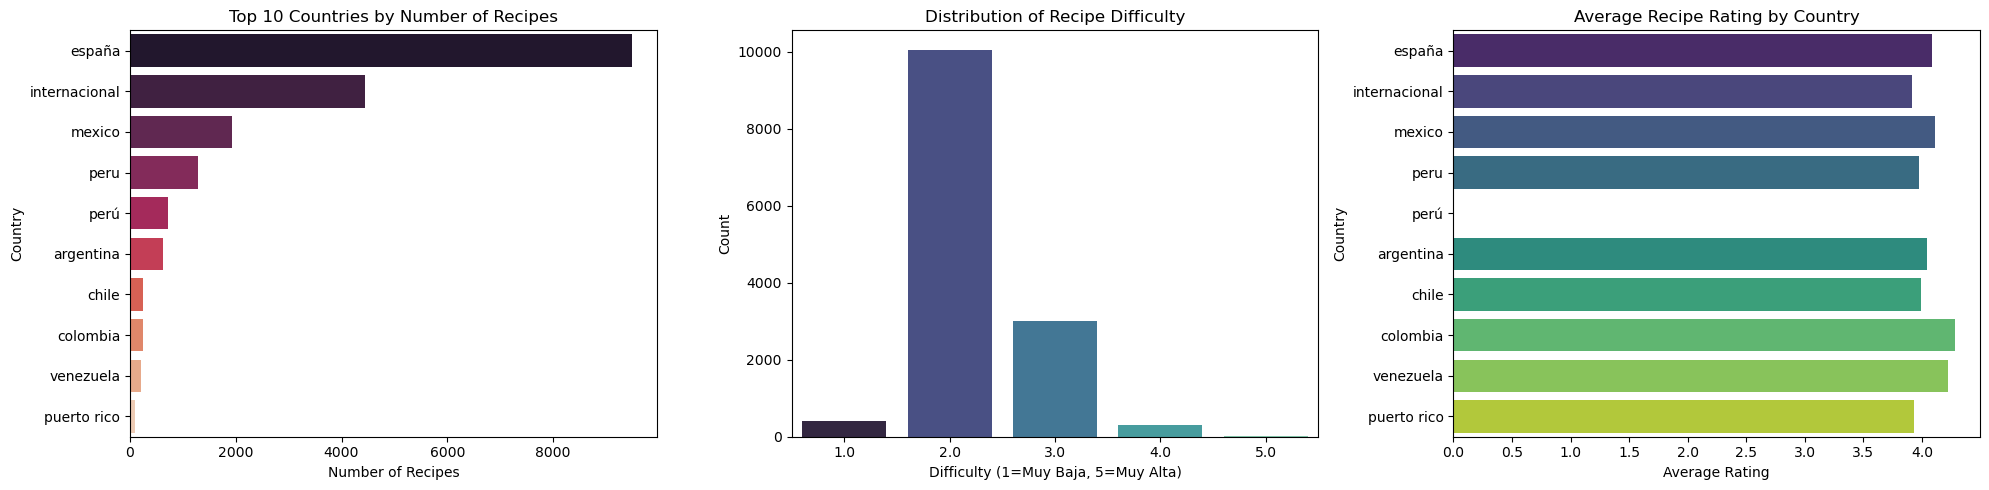

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Top 10 countries by number of recipes
top_countries = df['pais'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, ax=axes[0], palette='rocket')
axes[0].set_title('Top 10 Countries by Number of Recipes')
axes[0].set_xlabel('Number of Recipes')
axes[0].set_ylabel('Country')

# 2. Distribution of recipe difficulty
sns.countplot(x='dificultad', data=df, ax=axes[1], palette='mako')
axes[1].set_title('Distribution of Recipe Difficulty')
axes[1].set_xlabel('Difficulty (1=Muy Baja, 5=Muy Alta)')
axes[1].set_ylabel('Count')

# 3. Average rating by country (top 10 by count)
avg_rating = df.groupby('pais')['valoracion'].mean().loc[top_countries.index]
sns.barplot(x=avg_rating.values, y=avg_rating.index, ax=axes[2], palette='viridis')
axes[2].set_title('Average Recipe Rating by Country')
axes[2].set_xlabel('Average Rating')
axes[2].set_ylabel('Country')

plt.tight_layout()
plt.show()

Some useful additional visualizations could be:

1. **Recipe Count by Category and Country**  
    A heatmap or clustered bar chart showing the number of recipes per main category (e.g., "plato principal", "postre", etc.) for each top country. This helps identify which types of dishes are most popular in each country.

2. **Average Difficulty by Category**  
    A boxplot or barplot showing the distribution or average of recipe difficulty for each main category (e.g., "desayuno", "plato principal", etc.). This reveals which types of dishes tend to be more complex.

These two cuts (by country/category and by category/difficulty) provide insights into both the cultural and technical aspects of the recipes.

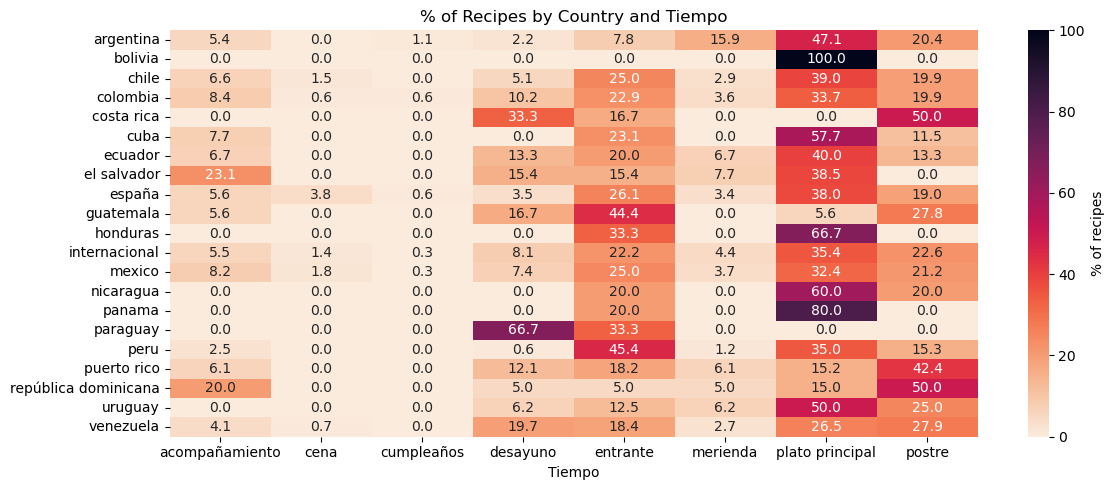

In [15]:
# Create a crosstab of counts
country_tiempo_counts = pd.crosstab(df['pais'], df['tiempo'])

# Convert counts to percentages by country
country_tiempo_pct = country_tiempo_counts.div(country_tiempo_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 5))
sns.heatmap(country_tiempo_pct.sort_index(), cmap='rocket_r', annot=True, fmt=".1f", cbar_kws={'label': '% of recipes'})
plt.title('% of Recipes by Country and Tiempo')
plt.ylabel(None)
plt.xlabel('Tiempo')
plt.tight_layout()
plt.show()

### Save DataFrame to CSV

In [7]:
df.to_csv("data/recetas_limpias.csv", index=False)